# El set de datos

Comencemos haciendo la lectura de este set de datos,

In [1]:
'''from api_somo import DataFetcher
import logging

# Setting up logging for the main script
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

api_url = "http://127.0.0.1:8000/database/filter-serie/"
params = {
    "station_name": "tumaco",
    "variable_name": "Precipitación acumulada",
    "processing_level_name": "Control de calidad",
    "start_date":"2010-01-01",
    "end_date":"2010-12-31"
    }

try:
    # 1. Fetch and process the data
    historical_series = DataFetcher.fetch_and_process_data(api_url, params)

    if historical_series.empty:
        raise ValueError("The historical series is empty.")

    # Additional processing with the historical series
    logger.info(f"Fetched historical series: {historical_series.head(0)}")

except Exception as e:
    logger.error(f"Error fetching historical series: {e}")
'''

'from api_somo import DataFetcher\nimport logging\n\n# Setting up logging for the main script\nlogging.basicConfig(level=logging.INFO)\nlogger = logging.getLogger(__name__)\n\napi_url = "http://127.0.0.1:8000/database/filter-serie/"\nparams = {\n    "station_name": "tumaco",\n    "variable_name": "Precipitación acumulada",\n    "processing_level_name": "Control de calidad",\n    "start_date":"2010-01-01",\n    "end_date":"2010-12-31"\n    }\n\ntry:\n    # 1. Fetch and process the data\n    historical_series = DataFetcher.fetch_and_process_data(api_url, params)\n\n    if historical_series.empty:\n        raise ValueError("The historical series is empty.")\n\n    # Additional processing with the historical series\n    logger.info(f"Fetched historical series: {historical_series.head(0)}")\n\nexcept Exception as e:\n    logger.error(f"Error fetching historical series: {e}")\n'

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

df = pd.read_csv(r"D:\master BigData\01 proyecto final\datos\cccp\remaster1\tum_prec_cc_2009.csv")
df.drop(columns=['category','qf'], inplace=True)
df


,timestamp,value
0,2009-02-01 05:10:00+00:00,0.0
1,2009-02-01 05:20:00+00:00,0.0
2,2009-02-01 05:30:00+00:00,0.0
3,2009-02-01 05:40:00+00:00,0.0
4,2009-02-01 05:50:00+00:00,0.0
...,...,...
47947,2009-12-31 04:20:00+00:00,0.0
47948,2009-12-31 04:30:00+00:00,0.0
47949,2009-12-31 04:40:00+00:00,0.0
47950,2009-12-31 04:50:00+00:00,0.0


___
## Pre-procesamiento de los datos
El objetivo de esta fase de pre-procesamiento es ajustar los datos al formato requerido por la Red LSTM para de esta forma poder entrenarla y validarla correctamente.

Esencialmente involucra tres fases:

Partición del dataset en los subsets de entrenamiento, validación y prueba
Generación del dataset supervisado (entradas y salidas del modelo)
Escalamiento de los datos
Veamos entonces en detalle cada una de estas fases, comenzando con la partición de los datos.

### Sets de entrenamiento, validación y prueba
El objetivo de la partición del dataset en los subsets de entrenamiento, validación y prueba es poder no sólo entrenar la Red LSTM sino validarla correctamente (verificando que no haya underfitting u overfitting).

En particular:

El set de entrenamiento (que en adelante será la variable train) se usará para encontrar los parámetros del modelo
El set de validación (val) nos permitirá verificar que no haya underfitting u overfitting del modelo y adicionalmente nos permitirá ajustar los hiperparámetros (como la tasa de aprendizaje, el número de iteraciones de entrenamiento y el tamaño del lote, entre otros).
El set de prueba (test) permitirá poner a prueba el mejor modelo encontrado durante el entrenamiento y la validación y nos permitirá evaluar la capacidad del modelo de generalizar (es decir de generar predicciones sobre datos que nunca antes ha visto).
A diferencia de otros modelos de Machine Learning, en el caso de series de tiempo y las Redes LSTM se debe garantizar que se generan las particiones sin mezclar aleatoriamente los datos.

Lo anterior implica que los sets train, val y test deberán ser obtenidos garantizando que todos los registros son consecutivos.

Teniendo esto en cuenta haremos la partición de la siguiente forma:

El set train contendrá la primera porción de la serie de tiempo (variable temperatura) correspondiente al 80% de la totalidad de los datos.
El set val contendrá la segunda porción de la serie de tiempo y correspondiente al 10% de la totalidad de los datos.
Finalmente, el set test contendrá la última porción de la serie de tiempo y correspondiente al 10% restante.
Para realizar esta partición implementaremos la función train_val_test_split que tomará como entrada la serie de tiempo (columna T (degC) del dataset) y los porcentajes correspondientes a los sets de entrenamiento, validación y prueba:

### Propósito
Esta herramienta permite analizar y visualizar la calidad y consistencia de las series temporales. A través de un reporte mensual y gráficos interactivos, se pueden identificar rápidamente patrones, datos ausentes, o inconsistencias en los registros.

### Beneficios:
1. **Evaluación Mensual de Registros:** Proporciona un desglose de la cantidad de datos disponibles mes a mes.
2. **Detección Temprana de Problemas:** Identifica anomalías como periodos sin datos o inconsistencias en los registros.
3. **Visualizaciones Claras:** Genera gráficos intuitivos para facilitar la interpretación de datos, permitiendo tomar decisiones informadas.

### Resultados:
- **Reporte Mensual:** Conteo detallado de registros procesados por mes.
- **Gráficos Generados:**
  1. **Serie Temporal Original:** Visualiza la evolución de los datos a lo largo del tiempo.
  2. **Conteo Mensual de Registros:** Muestra la cantidad de datos disponibles por mes para supervisar la consistencia.

---

### Impacto en la Gestión
Esta herramienta es clave para garantizar que los datos necesarios para análisis estratégicos estén completos y sean consistentes. Proporciona una visión integral del estado de las series temporales, apoyando la planificación y la resolución de problemas en la gestión de información.

In [3]:
def train_val_test_split(serie, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = serie.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = serie[0:Ntrain]
    val = serie[Ntrain:Ntrain+Nval]
    test = serie[Ntrain+Nval:]

    return train, val, test


tamaños que corresponden respectivamente al 80%, 10% y 10% del set de datos original.

## Dataset supervisado

En la función anterior podemos ver que la partición se realiza primero definiendo la cantidad de datos equivalente al porcentaje correspondiente (Ntrain, Nval y Ntst) y luego tomando las porciones correspondientes de la serie original para crear los subsets de entrenamiento (serie[0:Ntrain]), validación (serie[Ntrain:Ntrain+Nval]) y prueba (serie[Ntrain+Nval:]).

Habiendo creado esta función, simplemente debemos llamarla para crear los tres subsets de datos:

In [4]:
tr, vl, ts = train_val_test_split(df['value'])

# Imprimir en pantalla el tamaño de cada subset
print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (38361,)
Tamaño set de validación: (4795,)
Tamaño set de prueba: (4796,)


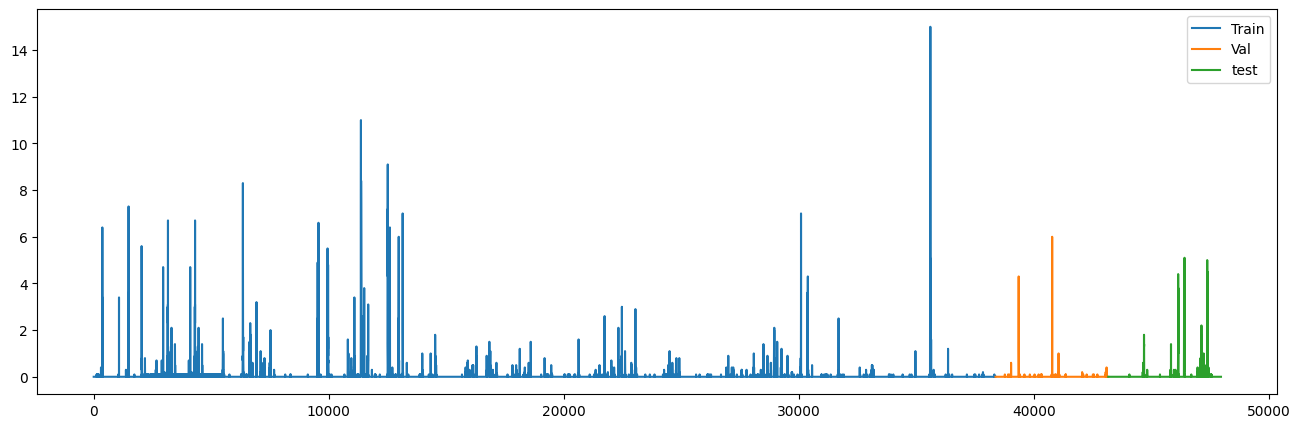

In [5]:
# Dibujar los subsets
from cProfile import label


fig, ax =plt.subplots(figsize = (16,5))
ax.plot(tr, label='Train')
ax.plot(vl, label='Val')
ax.plot(ts, label='test')
plt.legend()

In [6]:
def crear_dataset_supervisado(array, input_length, output_length):

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+input_length,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))
    
    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)
    
    return X, Y

In [7]:
# Definición de los hiperparámetros INPUT_LENGTH y OUTPUT_LENGTH
INPUT_LENGTH = 1440    # Registros de 24 horas consecutivas a la entrada
OUTPUT_LENGTH = 1    # El modelo va a predecir 1 hora a futuro

# Datasets supervisados para entrenamiento (x_tr, y_tr), validación
# (x_vl, y_vl) y prueba (x_ts, y_ts)
x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)


print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (36920, 1440, 1), y_tr: (36920, 1, 1)
Set de validación - x_vl: (3354, 1440, 1), y_vl: (3354, 1, 1)
Set de prueba - x_ts: (3355, 1440, 1), y_ts: (3355, 1, 1)


## Escalamiento de los datos

In [8]:
from sklearn.preprocessing import MinMaxScaler

def escalar_dataset(data_input):
    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers"
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])
    
    # Escalamiento Ys
    y_tr_s[:,:,0] = scalers[-1].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[-1].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[-1].transform(y_ts[:,:,0])

    # Conformar ` de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[0]

In [9]:
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

data_s, scaler = escalar_dataset(data_in)

x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

# Verificacion
print(f'Min x_tr/x_vl/x_ts sin escalamiento: {x_tr.min()}/{x_vl.min()}/{x_ts.min()}')
print(f'Min x_tr/x_vl/x_ts con escalamiento: {x_tr_s.min()}/{x_vl_s.min()}/{x_ts_s.min()}')

print(f'\nMin y_tr/y_vl/y_ts sin escalamiento: {y_tr.min()}/{y_vl.min()}/{y_ts.min()}')
print(f'Min y_tr/y_vl/y_ts con escalamiento: {y_tr_s.min()}/{y_vl_s.min()}/{y_ts_s.min()}')

print(f'\nMax x_tr/x_vl/x_ts sin escalamiento: {x_tr.max()}/{x_vl.max()}/{x_ts.max()}')
print(f'Max x_tr/x_vl/x_ts con escalamiento: {x_tr_s.max()}/{x_vl_s.max()}/{x_ts_s.max()}')

print(f'\nMax y_tr/y_vl/y_ts sin escalamiento: {y_tr.max()}/{y_vl.max()}/{y_ts.max()}')
print(f'Max y_tr/y_vl/y_ts con escalamiento: {y_tr_s.max()}/{y_vl_s.max()}/{y_ts_s.max()}')


Min x_tr/x_vl/x_ts sin escalamiento: 0.0/0.0/0.0
Min x_tr/x_vl/x_ts con escalamiento: -1.0/-1.0/-1.0

Min y_tr/y_vl/y_ts sin escalamiento: 0.0/0.0/0.0
Min y_tr/y_vl/y_ts con escalamiento: -1.0/-1.0/-1.0

Max x_tr/x_vl/x_ts sin escalamiento: 15.0/6.0/5.1
Max x_tr/x_vl/x_ts con escalamiento: 1.0/-0.19999999999999996/-0.32000000000000006

Max y_tr/y_vl/y_ts sin escalamiento: 15.0/6.0/5.1
Max y_tr/y_vl/y_ts con escalamiento: 1.0/-0.19999999999999996/-0.32000000000000006


## Creación y entrenamiento de la Red LSTM

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))

tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS = 128
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])

modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
modelo.add(Dense(OUTPUT_LENGTH, activation='linear'))

def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

#   COMPILACION

optimizador = RMSprop(learning_rate=5e-5)
modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

GPUs disponibles: []


d:\master BigData\01 proyecto final\codigos\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Entrenamiento del modelo

In [ ]:
EPOCHS = 80
BATCH_SIZE = 256
historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)


Epoch 1/80
145/145 - 697s - 5s/step - loss: 0.2654 - val_loss: 0.0233
Epoch 2/80
145/145 - 721s - 5s/step - loss: 0.0353 - val_loss: 0.0221
Epoch 3/80
145/145 - 796s - 5s/step - loss: 0.0349 - val_loss: 0.0200
Epoch 4/80
145/145 - 839s - 6s/step - loss: 0.0346 - val_loss: 0.0194
Epoch 5/80
145/145 - 1032s - 7s/step - loss: 0.0343 - val_loss: 0.0190
Epoch 6/80


---
## Análisis de Series Temporales Basado en Fechas

### Propósito
Este análisis permite identificar patrones mensuales en los datos mediante un desglose de la cantidad de registros disponibles por mes. La herramienta también ofrece una visualización clara para detectar posibles inconsistencias o ausencias de datos.

### Beneficios:
1. **Monitoreo Eficiente:** Permite entender la frecuencia y consistencia de los registros a lo largo del tiempo.
2. **Detección de Gaps:** Facilita la identificación de meses con datos ausentes o inconsistentes.
3. **Soporte a la Toma de Decisiones:** Proporciona una base visual para evaluar el comportamiento de los datos en diferentes periodos.

### Resultados:
- **Reporte Mensual:** Cantidad total de registros disponibles por mes.
- **Visualizaciones:**
  1. Tendencia temporal de los registros.
  2. Histograma mensual que muestra la distribución de registros.


In [ ]:
report_index = analyze_time_series_index(historical_series)
#print(report_index)

NameError: name 'analyze_time_series_index' is not defined

# Dashboard interactivos
una vez verificamos que coherencia temporal entonces podemos interactuar con la serie para obtener mas informacion
## 1. tabla de los datos con bandera de calidad: malo o inexistente 

In [5]:
from graphics_utils.express import fig_pie_month, fig_boxplot, fig_lineplot, fig_scatter

print('tabla de datos con inconsistencias')
print(historical_series[historical_series['qf'].isin([9, 4])])


tabla de datos con inconsistencias
                             value  qf
timestamp                             
2010-01-31 05:10:00+00:00 -99999.0   9
2010-01-31 05:20:00+00:00 -99999.0   9
2010-01-31 05:30:00+00:00 -99999.0   9
2010-01-31 05:40:00+00:00 -99999.0   9
2010-01-31 05:50:00+00:00 -99999.0   9
...                            ...  ..
2010-12-19 04:20:00+00:00 -99999.0   9
2010-12-19 04:30:00+00:00 -99999.0   9
2010-12-19 04:40:00+00:00 -99999.0   9
2010-12-19 04:50:00+00:00 -99999.0   9
2010-12-19 05:00:00+00:00 -99999.0   9

[1717 rows x 2 columns]


In [6]:

historical_series=historical_series
line_fig = fig_scatter(historical_series, params, color='qf')
line_fig.show()
pie_fig = fig_pie_month(historical_series, params)
pie_fig.show()
boxplot_fig = fig_boxplot(historical_series, params, color='month')
boxplot_fig.show()